In [144]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [96]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [97]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

In [98]:
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

In [99]:
# pandas, pandas_datareader, numpy and matplotlib
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot

In [172]:
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from pandas_datareader import data as pdr
import yfinance as yf

In [101]:
# from pandas_datareader import data

# # Only get the adjusted close.
# aapl = data.DataReader("AAPL", 
#                        start='2015-1-1', 
#                        end='2015-12-31', 
#                        data_source='yahoo')['Adj Close']

# aapl.plot(title='AAPL Adj. Closing Price')

#data = yf.download('MSFT', start = '2012-01-01', end='2017-01-01')

[*********************100%***********************]  1 of 1 completed


### 1. Loading the dataset

One of the most important steps in machine learning and predictive modeling is gathering good data. The following steps demonstrate the loading
of data from the Yahoo Finance (yfinance library) and FRED websites using the Pandas DataReader function.

In [103]:
start = '2010-01-01'; end = '2022-01-01'
stk_tickers = ['MSFT', 'IBM', 'GOOGL']
ccy_tickers = ['DEXJPUS', 'DEXUSUK']
idx_tickers = ['SP500', 'DJIA', 'VIXCLS']
stk_data = yf.download(stk_tickers, start=start, end=end)
ccy_data = web.DataReader(ccy_tickers, 'fred', start=start, end=end)
idx_data = web.DataReader(idx_tickers, 'fred', start=start, end=end)

[*********************100%***********************]  3 of 3 completed


Next, we define our dependent $(Y)$ and independent $(X)$ variables. The predicted
variable is the weekly return of Microsoft (MSFT). The number of trading days in a
week is assumed to be five, and I calculate the return using five trading days. For
independent variables, I use the correlated assets and the historical return of MSFT
at different frequencies.
The variables used as independent variables are lagged five-day return of stocks (IBM
and GOOG), currencies (USD/JPY and GBP/USD), and indices (S&P 500, Dow
Jones, and VIX), along with lagged 5-day, 15-day, 30-day and 60-day return of
MSFT.
The lagged five-day variables embed the time series component by using a time-delay
approach, where the lagged variable is included as one of the independent variables.
This step is reframing the time series data into a supervised regression–based model
framework.

In [105]:
return_period = 5
Y = np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).\
shift(-return_period)
Y.name = Y.name[-1]+'_pred'
X1 = np.log(stk_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(ccy_data).diff(return_period)
X3 = np.log(idx_data).diff(return_period)
X4 = pd.concat([np.log(stk_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3,\
return_period*6, return_period*12]], axis=1).dropna()

In [106]:
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT', 'MSFT_12DT']
X = pd.concat([X1, X2, X3, X4], axis=1)
dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.name]
X = dataset.loc[:, X.columns]

In [107]:
dataset.head()

,MSFT_pred,GOOGL,IBM,DEXJPUS,DEXUSUK,SP500,DJIA,VIXCLS,MSFT_DT,MSFT_3DT,MSFT_6DT,MSFT_12DT
2013-05-13,0.067203,0.018378,0.003146,0.024754,-0.016024,0.010008,0.008170,-0.008727,-0.021564,0.068928,0.143660,0.172029
2013-05-20,-0.001712,0.034717,0.025021,0.006850,-0.004457,0.019709,0.016012,0.036766,0.067203,0.080000,0.211562,0.241023
2013-05-28,-0.000857,-0.030464,0.000867,-0.002837,-0.007211,-0.005467,0.001416,0.079755,-0.001712,0.043926,0.206358,0.232490
2013-06-05,0.006306,-0.009965,-0.025229,-0.017494,0.017763,-0.024230,-0.022616,0.165549,-0.002871,0.036602,0.135030,0.228479
2013-06-12,-0.011783,0.014183,-0.007625,-0.039076,0.019622,0.002247,0.002313,0.060423,0.006306,0.004295,0.062803,0.226566


### 2. Ploting the data

The fastest way to learn more about the data is to plot it.
The visualization involves independently understanding each attribute of the dataset.
We will look at the scatterplot and the correlation matrix. These plots give us a sense
of the interdependence of the data. Correlation can be calculated and displayed for
each pair of the variables by creating a correlation matrix. Besides the relationship between independent and dependent variables, it also shows the correlation
among the independent variables. This is useful to know because some machine
learning algorithms like linear and logistic regression can have poor performance if
there are highly correlated input variables in the data:

<AxesSubplot:title={'center':'Correlation Matrix'}>

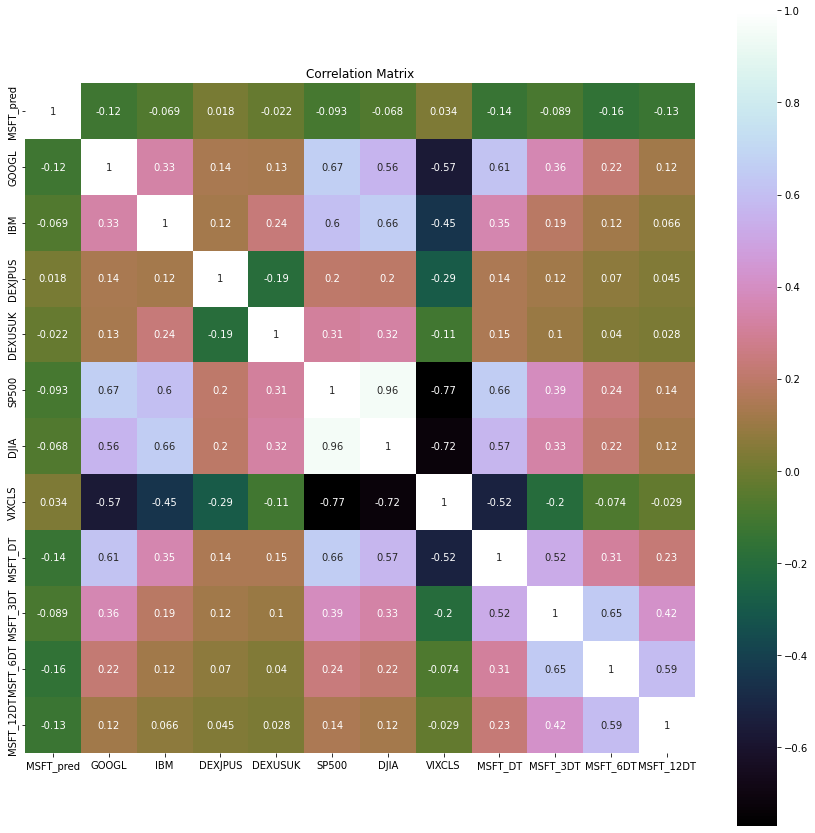

In [108]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Looking at the correlation plot, we see some
correlation of the predicted variable with the lagged 5-day, 15-day, 30-day, and 60-
day returns of MSFT. Also, we see a higher negative correlation of many asset returns
versus VIX, which is intuitive.
Next, we can visualize the relationship between all the variables in the regression
using the scatterplot matrix shown below:

<Figure size 2160x2160 with 0 Axes>

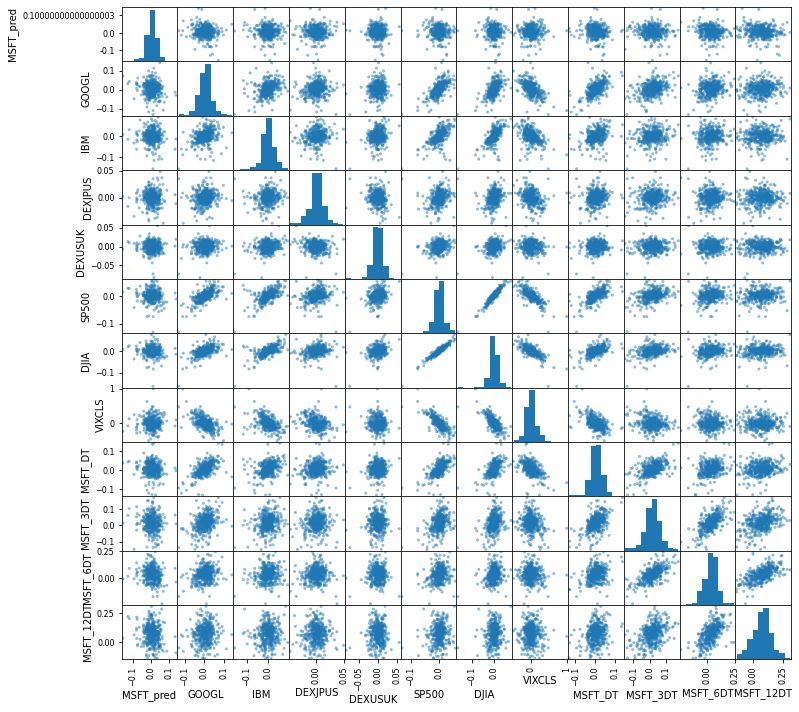

In [173]:
pyplot.figure(figsize=(30,30))
scatter_matrix(dataset,figsize=(12,12))
pyplot.show()

Looking at the scatterplot, we see some linear relationship of the predicted variable with the lagged 15-day, 30-day, and 60-day
returns of MSFT. 

### 3. Time series plotting

We delve into the time series analysis and look at the decomposition of the time series of the predicted variable into trend and seasonality
components:

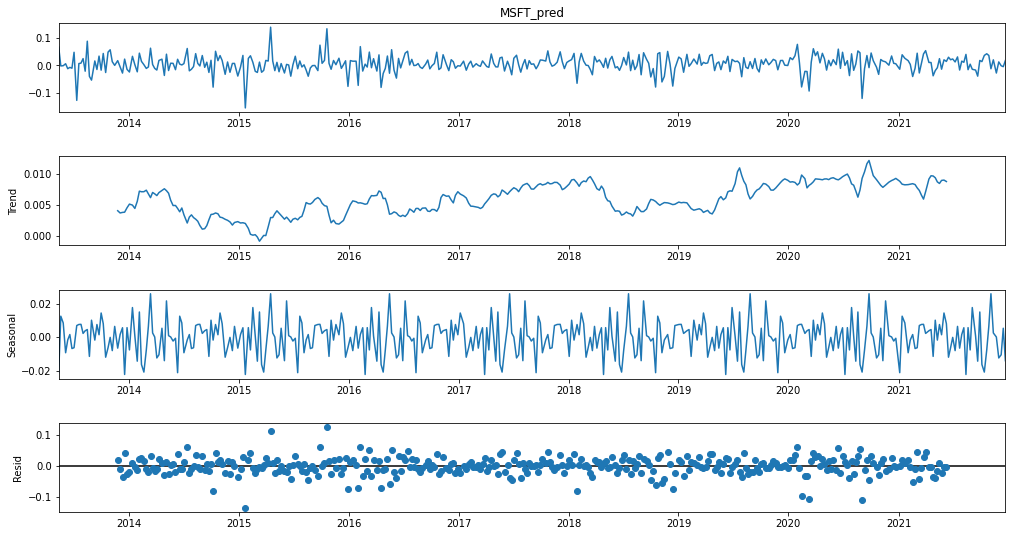

In [110]:
res = sm.tsa.seasonal_decompose(Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

### 4. Data preparation
We can see that for MSFT there has been a general upward trend in the return series. This may be due to the large run-up of MSFT in the recent years, causing more positive weekly return data points than negative. The trend may show up in the constant/bias terms in our models. The residual term is relatively small
over the entire time series.

### 5. Evaluate models
#### 5.1 Train-test split and evaluation metrics. 
It is a good idea to partition the original dataset into a training set and a test set. The test set is a sample of the data that we hold back from our analysis and modeling. We use it right at the end of our project to confirm the performance of our final model. It is the final
test that gives us confidence on our estimates of accuracy on unseen data. We will use 80% of the dataset for modeling and use 20% for testing. With time series data, the sequence of values is important. So we do not distribute the dataset into training and
test sets in random fashion, but we select an arbitrary split point in the ordered list of
observations and create two new datasets:

In [111]:
validation_size = 0.2
train_size = int(len(X) * (1-validation_size))
X_train, X_test = X[0:train_size], X[train_size:len(X)]
Y_train, Y_test = Y[0:train_size], Y[train_size:len(X)]

#### 5.2 Test options and evaluation metrics
To optimize the various hyperparameters of
the models, we use ten-fold cross validation (CV) and recalculate the results ten times
to account for the inherent randomness in some of the models and the CV process.
We will evaluate algorithms using the mean squared error metric. This metric gives
an idea of the performance of the supervised regression models.

In [112]:
num_folds = 10
scoring = 'neg_mean_squared_error'

#### 5.3 Compare models & Algorithm


In [174]:
#?sm.tsa.seasonal_decompose

In [114]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [115]:
models.append(('MLP', MLPRegressor()))

In [116]:
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

Once we have selected all the models, we loop over each of them. First, we run the kfold analysis. Next, we run the model on the entire training and testing dataset. All the algorithms use default tuning parameters. We will calculate the mean and
standard deviation of the evaluation metric for each algorithm and collect the results
for model comparison later:

In [117]:
names = []
kfold_results = []
test_results = []
train_results = []
for name, model in models:
    names.append(name)
    ## k-fold analysis:
    kfold = KFold(n_splits=num_folds, random_state=None)
    #converted mean squared error to positive. The lower the better
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, \
    scoring=scoring)
    kfold_results.append(cv_results)
    # Full Training period
    res = model.fit(X_train, Y_train)
    train_result = mean_squared_error(res.predict(X_train), Y_train)
    train_results.append(train_result)
    # Test results
    test_result = mean_squared_error(res.predict(X_test), Y_test)
    test_results.append(test_result)

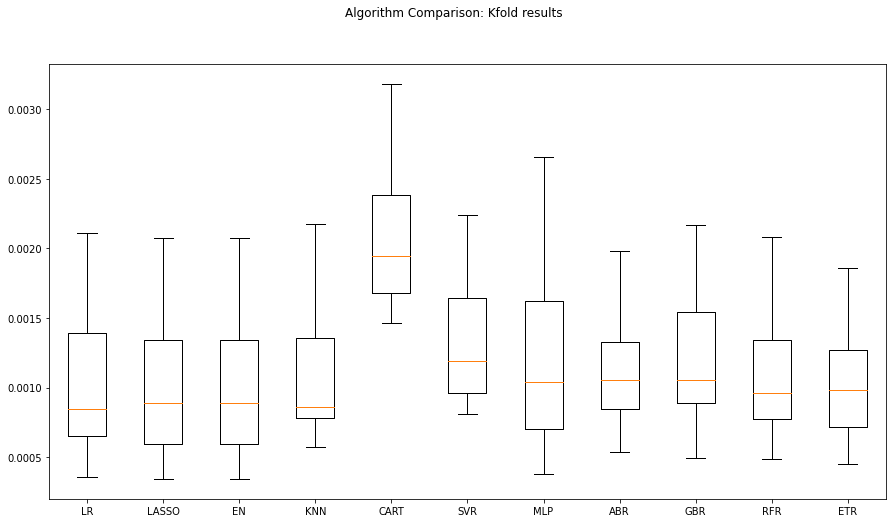

In [118]:
#cross validation results
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison: Kfold results')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

Although the results of a couple of the models look good, we see that the linear
regression and the regularized regression including the lasso regression (LASSO) and
elastic net (EN) seem to perform best. This indicates a strong linear relationship
between the dependent and independent variables. Going back to the exploratory
analysis, we observed a good correlation and linear relationship of the target variables with
the different lagged MSFT variables.

Let us look at the errors of the test set as well:

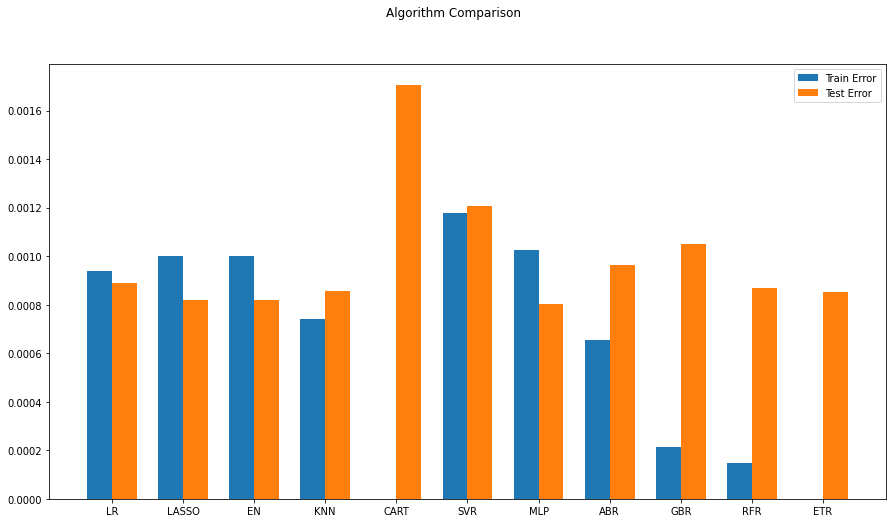

In [119]:
# compare algorithms
fig = pyplot.figure()
ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, train_results, width=width, label='Train Error')
pyplot.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

Examining the training and test error, we still see a stronger performance from the
linear models. Some of the algorithms, such as the decision tree regressor (CART),
overfit on the training data and produced very high error on the test set. Ensemble
models such as gradient boosting regression (GBR) and random forest regression
(RFR) have low bias but high variance. We also see that the artificial neural network
algorithm (shown as MLP in the chart) shows higher errors in both the training and
test sets. This is perhaps due to the linear relationship of the variables not captured
accurately by ANN, improper hyperparameters, or insufficient training of the model.

We now look at some of the time series and deep learning models that can be used.
Once we are done creating these, we will compare their performance against that of
the supervised regression–based models. Due to the nature of time series models, we
are not able to run a k-fold analysis. We can still compare our results to the other
models based on the full training and testing results.

#### 5.4 Time series models: ARIMA - LSTM

The models used so far already
embed the time series component by using a time-delay approach, where the lagged
variable is included as one of the independent variables. However, for the time series–based models we do not need the lagged variables of MSFT as the independent variables. Hence, as a first step we remove MSFT’s previous returns for these models.
We can use all other variables as the exogenous variables in these models.
Let us first prepare the dataset for ARIMA models by having only the correlated varriables as exogenous variables:

In [120]:
X_train_ARIMA=X_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', \
'VIXCLS']]
X_test_ARIMA=X_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', \
'VIXCLS']]
tr_len = len(X_train_ARIMA)
te_len = len(X_test_ARIMA)
to_len = len(X)

We now configure the ARIMA model with the order $(1,0,0)$ and use the independent
variables as the exogenous variables in the model. The version of the ARIMA model
where the exogenous variables are also used is known as the ARIMAX model, where
$X$ represents exogenous variables:

In [121]:
import statsmodels.api as sm

In [122]:
modelARIMA=sm.tsa.arima.ARIMA(endog=Y_train,exog=X_train_ARIMA,order=(1,0,0))
model_fit = modelARIMA.fit()

In [123]:
?ARIMA

Init signature: ARIMA(*args, **kwargs)
Docstring:     
ARIMA has been deprecated in favor of the new implementation

See Also
--------
statsmodels.tsa.arima.model.ARIMA
    ARIMA models with a variety of parameter estimators
statsmodels.tsa.statespace.SARIMAX
    SARIMAX models estimated using MLE
File:           ~/Library/Python/3.7/lib/python/site-packages/statsmodels/tsa/arima_model.py
Type:           type
Subclasses:     


In [124]:
error_Training_ARIMA = mean_squared_error(Y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start = tr_len -1 ,end = to_len -1, \
exog = X_test_ARIMA)[1:]
error_Test_ARIMA = mean_squared_error(Y_test,predicted)
error_Test_ARIMA

0.0008880187623775143

Now let’s prepare the dataset for the LSTM model. We need the data in the form of
arrays of all the input variables and the output variables. The logic behind the LSTM is that data is taken from the previous day (the data of all
the other features for that day—correlated assets and the lagged variables of MSFT)
and we try to predict the next day. Then we move the one-day window with one day
and again predict the next day. We iterate like this over the whole dataset (of course
in batches). The code below will create a dataset in which $X$ is the set of independent
variables at a given time $(t)$ and $Y$ is the target variable at the next time $(t + 1)$:

In [125]:
seq_len = 2 #Length of the seq for the LSTM
Y_train_LSTM, Y_test_LSTM = np.array(Y_train)[seq_len-1:], np.array(Y_test)
X_train_LSTM = np.zeros((X_train.shape[0]+1-seq_len, seq_len, X_train.shape[1]))
X_test_LSTM = np.zeros((X_test.shape[0], seq_len, X.shape[1]))
for i in range(seq_len):
    X_train_LSTM[:, i, :] = np.array(X_train)[i:X_train.shape[0]+i+1-seq_len, :]
    X_test_LSTM[:, i, :] = np.array(X)\
    [X_train.shape[0]+i-1:X.shape[0]+i+1-seq_len, :]

In [126]:
# LSTM Network
def create_LSTMmodel(learn_rate = 0.01, momentum=0):
    # create model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train_LSTM.shape[1],\
    X_train_LSTM.shape[2])))
    #More cells can be added if needed
    model.add(Dense(1))
    optimizer = SGD(lr=learn_rate, momentum=momentum)
    model.compile(loss='mse', optimizer='adam')
    return model
LSTMModel = create_LSTMmodel(learn_rate = 0.01, momentum=0)
LSTMModel_fit = LSTMModel.fit(X_train_LSTM, Y_train_LSTM, \
validation_data=(X_test_LSTM, Y_test_LSTM),\
epochs=330, batch_size=72, verbose=0, shuffle=False)

Now, we fit the LSTM model with the data and observe the changes in the model performance metric over time simultaneously in the training and test dataset.


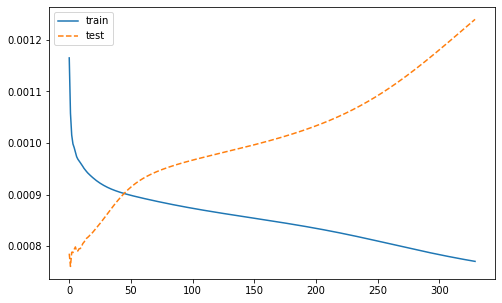

In [127]:
pyplot.plot(LSTMModel_fit.history['loss'], label='train', )
pyplot.plot(LSTMModel_fit.history['val_loss'], '--',label='test',)
pyplot.legend()
pyplot.show()

In [128]:
#some code to calculate the error for LSTM model
error_Training_LSTM = mean_squared_error(Y_train_LSTM,\
                        LSTMModel.predict(X_train_LSTM))
predicted = LSTMModel.predict(X_test_LSTM)
error_Test_LSTM = mean_squared_error(Y_test,predicted)

Now, in order to compare the time series and the deep learning models, we append the result of these models to the result of supervised regression (the based models)

In [151]:
test_results.append(error_Test_ARIMA)
test_results.append(error_Test_LSTM)
train_results.append(error_Training_ARIMA)
train_results.append(error_Training_LSTM)
names.append("ARIMA")
names.append("LSTM")
print(names)

['LR', 'LASSO', 'EN', 'KNN', 'CART', 'SVR', 'MLP', 'ABR', 'GBR', 'RFR', 'ETR', 'ARIMA', 'LSTM', 'ARIMA', 'LSTM', 'ARIMA', 'LSTM']


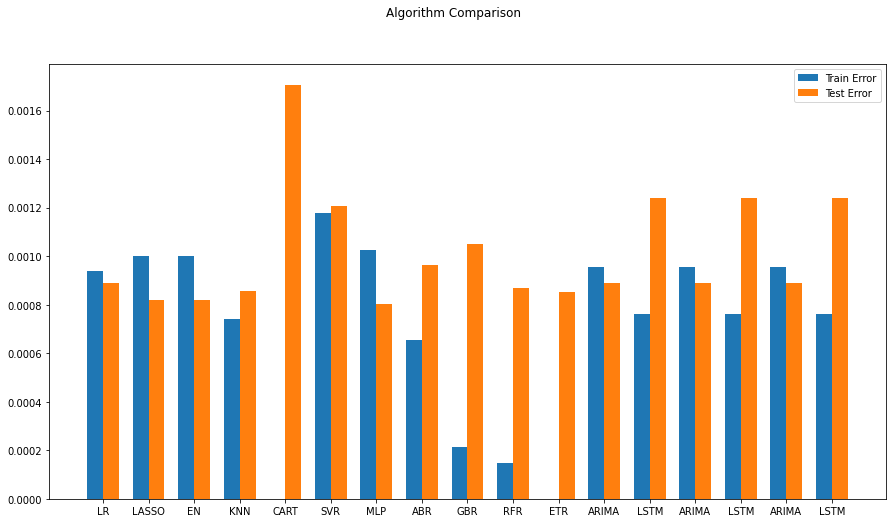

In [171]:
# compare algorithms

fig, ax = plt.subplots(figsize=(12,7))
# compare algorithms

ind = np.arange(len(names)) # the x locations for the groups
width = 0.35 # the width of the bars
fig.suptitle('Algorithm Comparison')

ax.set_xticks(ind)
ax.set_xticklabels(names)
ax.bar(ind - width/2, train_results, width=width, label='Train Error')
ax.bar(ind + width/2, test_results, width=width, label='Test Error')
fig.set_size_inches(15,8)
plt.legend()
plt.show()

Look at the chart above, we can see the time series ARIMA model comparable to the linear regression models (LR), Lasso Regression (LASSO), and Elastic Net (EN).
This is because of the strong linear relationship as we saw before. The LSTM model performs decently; however, the ARIMA model outperforms the LSTM model in the testing dataset.
We therefore select the ARIMA model as our final model. In next steps, we will fine tune the ARIMA model and use it to predict the future stock price.

### 6. Model tuning and grid search

Model tuning and grid search
Let us perform the model tuning of the ARIMA model.
The ARIMA model is generally represented as ARIMA $(p, d, q)$ model, where $p$ is the order of the autoregressive part, $d$ is the degree of the first differencing involved,
and $q$ is the order of the moving average part. The paramteres of the ARIMA model was set to $(1,0,0$) in default. We can perform a grid search to find the best parameters and select the combination that minimizes the mean squared error for the ARIMA model.

In [130]:
def evaluate_arima_model(arima_order):
    ARIMA_m = sm.tsa.arima.ARIMA(endog=Y_train,exog=X_train_ARIMA,order=arima_order)
    model_fit = ARIMA_m.fit()
    error = mean_squared_error(Y_train, model_fit.fittedvalues)
    return error

#evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.7f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.7f' % (best_cfg, best_score))

In [131]:
#The result
# evaluate parameters
p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
evaluate_models(p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=0.0009625
ARIMA(0, 0, 1) MSE=0.0009553
ARIMA(0, 1, 0) MSE=0.0018175
ARIMA(0, 1, 1) MSE=0.0010047
ARIMA(1, 0, 0) MSE=0.0009570
ARIMA(1, 0, 1) MSE=0.0009543
ARIMA(1, 1, 0) MSE=0.0014896
ARIMA(1, 1, 1) MSE=0.0010285
ARIMA(2, 0, 0) MSE=0.0009510
ARIMA(2, 0, 1) MSE=0.0009544
ARIMA(2, 1, 0) MSE=0.0012855
ARIMA(2, 1, 1) MSE=0.0009974
Best ARIMA(2, 0, 0) MSE=0.0009510


We observe that the ARIMA model with parameters $(2,0,0)$ is the best result of all the combinations tested in the grid search, although there is not a significant difference in the MSE with order combination. This imply that the model with the autoregressive lag of two periods (p=2) yields the best result. We might not forget the fact that there are chances other exogenous variables in the model that influence the order of the best ARIMA model.

### 7. Finalize Model

In the final step, we will check the finalized model on the test set

In [143]:
# prepare model
ARIMA_fine_tuned = sm.tsa.arima.ARIMA(endog=Y_train,exog=X_train_ARIMA,order=[2,0,0])
model_fit_fine_tuned = ARIMA_fine_tuned.fit()
# estimate accuracy on validation set
predicted_fine_tuned = model_fit_fine_tuned.predict(start = tr_len -1 ,\
end = to_len -1, exog = X_test_ARIMA)[1:]

In [133]:
#Output
print(mean_squared_error(Y_test,predicted_fine_tuned))

0.0008966912325023936


The MSE of the model on the testing set looks good and it is actually less than that of the training set.
In the last step, will can visualize the output of the selected model and compare the modeled data against the actual data. In order to visualize the chart, we convert the return time series to a price time series. We assume the price at the begining of the testing dataset as one for the benefit of simplicity. Let us monitor the plot of actual versus predicted data:

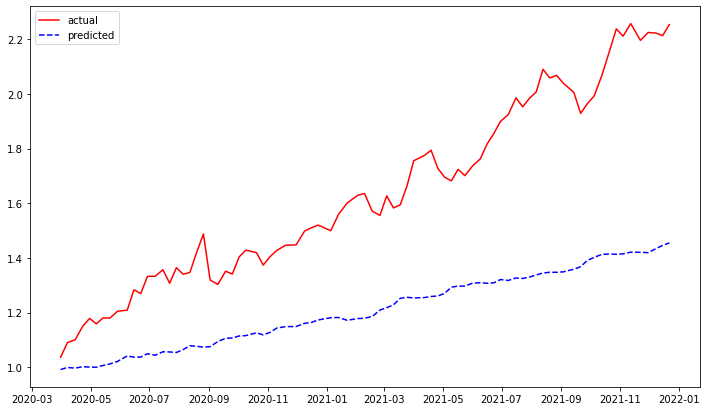

In [142]:
# visualizing the actual data versus predicted data
import matplotlib.pyplot as plt

predicted_fine_tuned.index = Y_test.index
plt.figure(figsize=(12,7))
pyplot.plot(np.exp(Y_test).cumprod(), 'r', label='actual',)
# plotting t, a separately
pyplot.plot(np.exp(predicted_fine_tuned).cumprod(), 'b--', label='predicted')
pyplot.legend()
pyplot.rcParams["figure.figsize"] = (8,5)
pyplot.show()

Looking at the chart, we clearly see the trend has been captured by the
model. The predicted series is less volatile compared to the actual time series, and it
aligns with the actual data for the first few months of the test set. A point to note is
that the purpose of the model is to compute the next day’s return given the data
observed up to the present day, and not to predict the stock price several days in the
future given the current data. Hence, a deviation from the actual data is expected as
we move away from the beginning of the test set. The model seems to perform well
for the first few months, with deviation from the actual data increasing six to seven
months after the beginning of the test set.

### 8. Conclusion

I can conclude that simple models—linear regression, regularized regression (Lasso and elastic net) — along with the time series models, such as ARIMA, are prom‐
ising modeling approaches for stock price prediction problems. This approach aids
us deal with overfitting and underfitting, which are some of the key challenges in predicting problems in finance.
I should also note that we can use a wider set of indicators, such as P/E ratio, trading volume, technical indicators, which might lead to better results.
Overall, we might create a supervised-regression and time series modeling framework that
allows us to conduct stock price prediction using historical data. This framework
generates results to analyze risk and profitability before risking any capital.